# Multivariate Multi-Step CNN Models
ref: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/ section "Multivariate Multi-Step CNN Models"

In [1]:
from data_loader import load_names_from_web, holdout_split

In [2]:
# pip install keras-tuner

In [59]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack

import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten, Conv1D, MaxPooling1D, Input
from keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


## load and format data

In [5]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True, use_existing_files=True)
dfraw.sample(5)

,state,year,name,M/F,count
196800,US,2003,Rosanna,F,52
2065424,US,2019,Willemina,F,8
465073,US,2013,Angelinna,F,6
30585,US,2014,Marisol,F,343
1305750,US,1950,Buell,M,12


In [6]:
df1 = dfraw.copy()
df1['name_g'] = df1['name'] + '_' + df1['M/F']
df1.drop(columns=['state', 'name', 'M/F'], inplace=True)
df1.head()

,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,19968,Madison_F
3,2000,17998,Ashley_F
4,2000,17712,Sarah_F


In [7]:
# for now, lets just look at names that have been used continuously throughout the years.
# for later iterations, can replace this cell with another cell creating df2
unique_years = df1['year'].nunique()
complete_records = df1.groupby('name_g').filter(lambda x: x['year'].nunique() == unique_years)
df2 = complete_records.reset_index(drop=True)
print(df2.shape, 'names: ', df2['name_g'].nunique())
df2.head()

(202702, 3) names:  2357


,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,17712,Sarah_F
3,2000,17265,Samantha_F
4,2000,15711,Jessica_F


In [8]:
# reformat the dataframe with a column for each name
df3 = df2.pivot(index='year', columns='name_g', values='count')
print(df3.shape)
df3.head()

(86, 2357)


name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
year,,,,,,,,,,,,,,,,,,,,,
1937,465,52,25,63,91,25,45,39,217,31,...,32,15,49,17,147,16,33,12,72,8
1938,477,56,21,55,87,28,50,49,212,37,...,31,15,62,15,145,16,36,11,65,17
1939,471,70,24,56,95,31,53,34,197,31,...,33,8,61,12,127,13,47,15,55,19
1940,514,57,37,54,101,33,48,34,219,23,...,18,18,68,16,128,19,35,13,54,18
1941,562,50,32,66,121,17,40,38,194,29,...,30,10,52,11,106,21,25,14,60,21


In [77]:
df3.iloc[:,0:10].to_csv('temp2.csv')

In [9]:
# make the df into an array
df3array = df3.to_numpy()
print(np.shape(df3array))
df3array[:2,:2]

(86, 2357)


array([[465,  52],
       [477,  56]])

## split training and test

In [11]:
num_years_to_predict = 2

In [12]:
# look at the end of dataframe, so I can make sure my numpy arrays are correct
df3.tail(num_years_to_predict+2)

name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
year,,,,,,,,,,,,,,,,,,,,,
2019,5534,91,623,81,2463,65,9171,182,2061,609,...,130,28,1596,10,436,90,37,56,5067,55
2020,5087,88,595,53,2124,62,7891,219,1897,509,...,138,20,1354,14,524,83,46,27,4791,85
2021,4843,98,523,64,1944,48,6969,213,1908,477,...,150,14,1484,17,491,83,32,22,4724,103
2022,4496,81,508,58,1753,53,6254,190,1824,429,...,142,27,1338,18,434,90,32,38,4984,75


In [13]:
# create train. show last two rows
train = df3array[:-num_years_to_predict,:]
print(train.shape)
train[-2:,:]

(84, 2357)


array([[5534,   91,  623, ...,   56, 5067,   55],
       [5087,   88,  595, ...,   27, 4791,   85]])

In [14]:
# create test. Show it
test = df3array[-num_years_to_predict:,:]
print(test.shape)
test

(2, 2357)


array([[4843,   98,  523, ...,   22, 4724,  103],
       [4496,   81,  508, ...,   38, 4984,   75]])

## model 1

In [15]:
n_steps_in = 10
n_steps_out = num_years_to_predict

In [16]:
# function to split a multivariate sequence into samples
def split_sequences1(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [30]:
X2, y2 = split_sequences1(train, n_steps_in, n_steps_out)
print('shapes', X2.shape, y2.shape)

n_output = y2.shape[1] * y2.shape[2]
y3 = y2.reshape((y2.shape[0], n_output))
n_features = X2.shape[2]

shapes (80, 3, 2357) (80, 2, 2357)


In [18]:
# define model
model = Sequential()
# added:
model.add(Input(shape=(n_steps_in, n_features)))
# removed , input_shape=(n_steps_in, n_features):
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [19]:
# this might be slow. For 10 in, 2 out, this took less than 3 minutes on laptop



# fit model
model.fit(X2, y3, epochs=7000, verbose=0)

## predict 1

In [20]:
x_input = train[-n_steps_in:, :]
print(x_input.shape)
x_input = x_input.reshape((1, n_steps_in, n_features))
x_input

(10, 2357)


array([[[7619,  340, 1065, ...,   29, 6307,   39],
        [7538,  343, 1037, ...,   25, 6464,   40],
        [7315,  245,  907, ...,   25, 5974,   31],
        ...,
        [5986,  120,  655, ...,   49, 5121,   50],
        [5534,   91,  623, ...,   56, 5067,   55],
        [5087,   88,  595, ...,   27, 4791,   85]]])

In [21]:
yhat = model.predict(x_input, verbose=0)
print(yhat.shape)

(1, 4714)


In [22]:
yhat2 = yhat.reshape(num_years_to_predict,n_features) #num years to predict, width of (train) array

In [23]:
yhat2

array([[4636.421   ,   26.443882,  505.1907  , ...,   99.01329 ,
        4109.7603  ,   54.24434 ],
       [4063.029   ,   38.0161  ,  426.49164 , ...,  137.20671 ,
        3998.6953  ,   68.69316 ]], dtype=float32)

## evaluate

In [24]:
# into dataframes
# plot some
# calc score
df_pred = pd.DataFrame(yhat2, columns = df3.columns)
max_train_year = df2['year'].max() - num_years_to_predict
new_index = range(max_train_year + 1, max_train_year + 1 + len(df_pred))
df_pred.index = new_index
df_pred.head()            

name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
2021,4636.420898,26.443882,505.190704,83.036331,2363.388184,67.480392,7429.415527,157.936157,1969.325562,529.564209,...,115.413635,19.036613,1627.951660,-0.010555,470.281860,115.055458,26.834694,99.013290,4109.760254,54.244339
2022,4063.029053,38.016102,426.491638,61.381126,1970.617798,63.838039,6263.964844,167.508972,1671.524048,424.700867,...,119.522385,26.188234,1299.660156,11.518377,493.763184,103.629738,39.041012,137.206711,3998.695312,68.693161


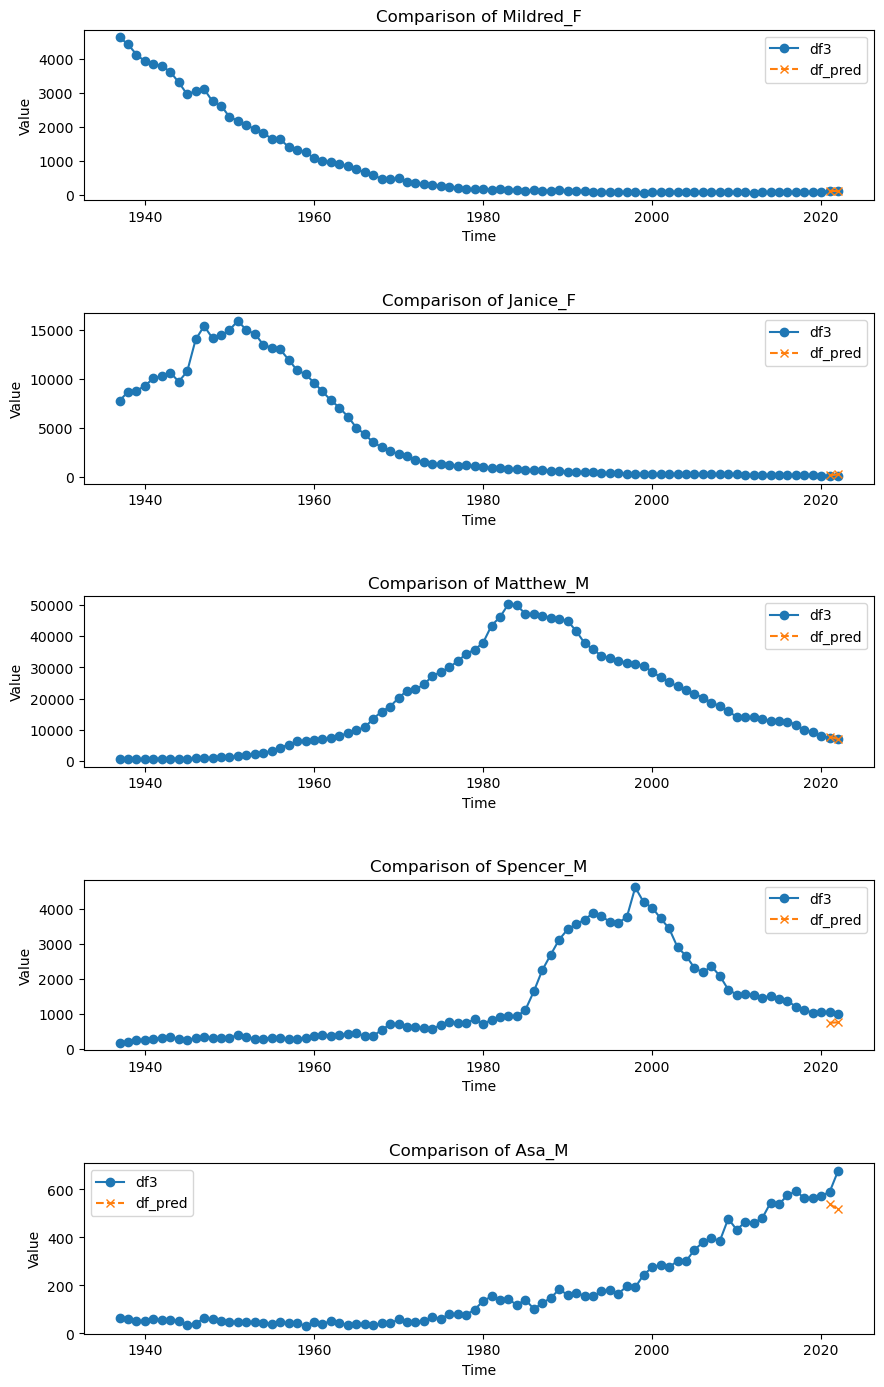

In [25]:
# plot some
num_to_plot = 5
np.random.seed(42)
columns_to_plot = np.random.choice(df3.columns, size=5, replace=False)
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(df3.index, df3[col], label='df3', marker='o', linestyle='-')
    axes[i].plot(df_pred.index, df_pred[col], label='df_pred', marker='x', linestyle='--')
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()

plt.show()


### zoom-in to recent years for another view of predictions

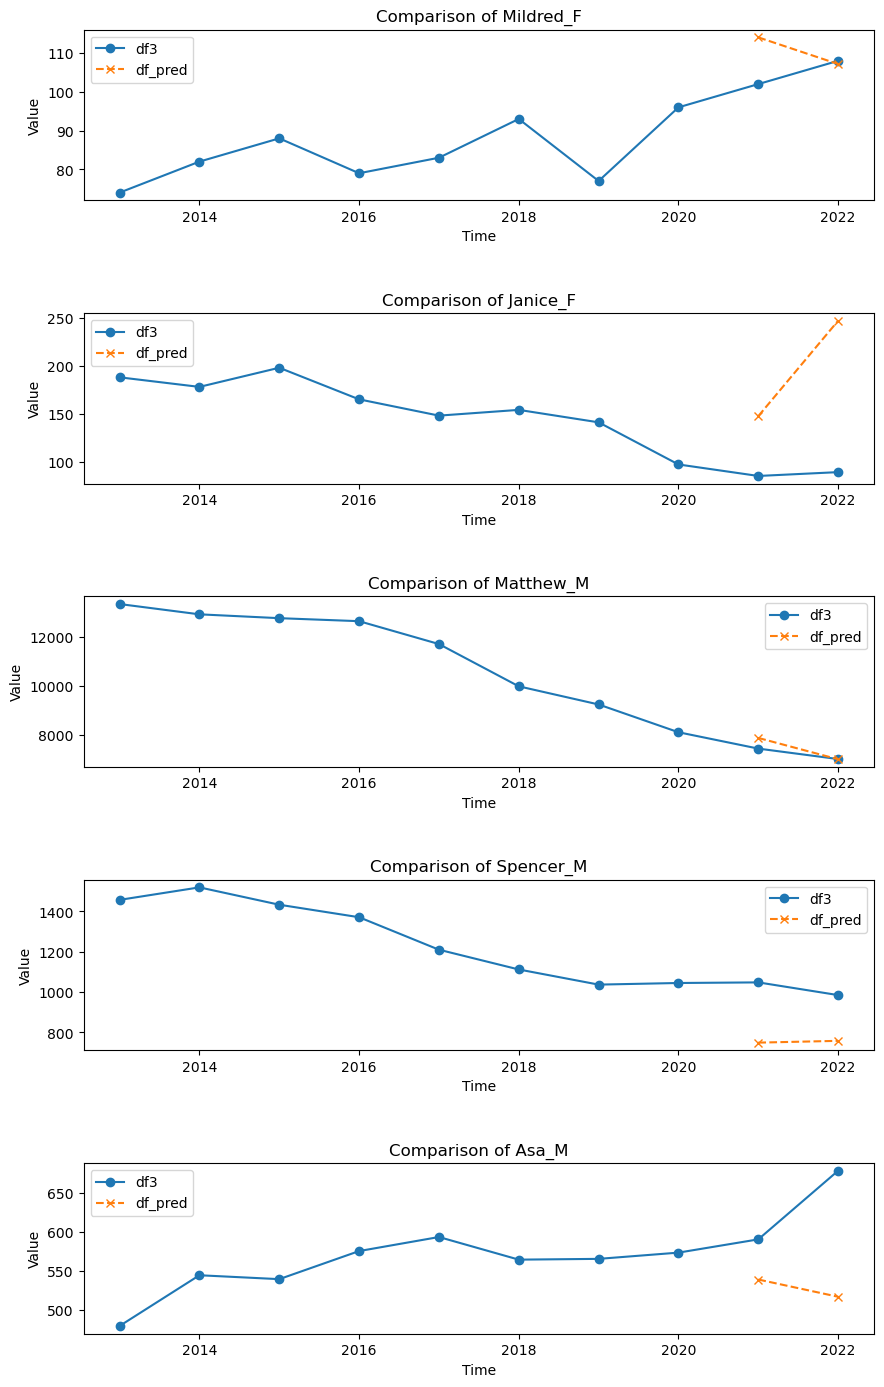

In [26]:
num_years_to_show = 10
num_to_plot = 5
np.random.seed(42)
columns_to_plot = np.random.choice(df3.columns, size=5, replace=False)
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(df3.index[-num_years_to_show:], df3[col].tail(num_years_to_show), label='df3', marker='o', linestyle='-')
    axes[i].plot(df_pred.index, df_pred[col], label='df_pred', marker='x', linestyle='--')
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()

plt.show()


## tune
I will try to ONLY take df3array from the above code. All other variables are meant to be set below.

In [54]:
df3array.shape

(86, 2357)

df3array: rows are years, columns are names

I will change the way the above NN works. I will consider the names as independent: they don't affect each other. However, they might have similar shapes at different times. So when making predictions for any one time series, I want the model to have learned from all of the individual time series. The shape of one time series in the past won't affect a different time series, but it might have a shape that helps predict the other time series.

So first I am going to change split_sequences to get all of the sequences from ALL names (without having a sequence span two different names).

In [55]:
def split_sequences2(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(sequences.shape[1]):  # Iterate over each time series independently
        for j in range(len(sequences)):
            end_ix = j + n_steps_in
            out_end_ix = end_ix + n_steps_out
            if out_end_ix > len(sequences):
                break
            seq_x, seq_y = sequences[j:end_ix, i], sequences[end_ix:out_end_ix, i]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

while the model is trained on sequences of exactly 10 (or whatever) years, the convolutional layers within it have the capacity to identify and learn from important features and patterns occurring within shorter intervals of those sequences.

In [72]:
n_steps_in, n_steps_out = 10, 2
X, y = split_sequences2(df3array, n_steps_in, n_steps_out)

In [60]:
n_output = n_steps_out
y = y.reshape((y.shape[0], n_output))

# Split data into training and testing sets for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = 1  # Since we're now treating each time series as independent

model = Sequential([
    Input(shape=(n_steps_in, n_features)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(n_output)
])

model.compile(optimizer='adam', loss='mse')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [61]:
%%time
# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 1691877.8750 - val_loss: 606210.8750
Epoch 2/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 678802.5625 - val_loss: 567957.6875
Epoch 3/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step - loss: 591068.9375 - val_loss: 524948.5000
Epoch 4/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 444us/step - loss: 515096.4688 - val_loss: 567943.6875
Epoch 5/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step - loss: 552951.0000 - val_loss: 555763.6875
Epoch 6/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 413us/step - loss: 577922.0625 - val_loss: 530700.1250
Epoch 7/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 408us/step - loss: 593966.6875 - val_loss: 738927.0000
Epoch 8/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step - loss: 581110.5625 - val_loss: 552072.3750
Epoch 9/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 418us/step - loss: 619371.0000 - val_loss: 519354.6250
Epoch 10/200
4420/4420 ━━━━━━━━━━━━━━━━━━━━ 2s 501us/step - loss: 550616.8750 - val_loss: 

In [62]:
last_points = df3array[-n_steps_in:].reshape(1, n_steps_in, -1)  # Reshaping for the model

# Making predictions for the next `n_steps_out` years for all names
predicted = model.predict(last_points)
predicted = predicted.reshape(n_steps_out, -1)  # Reshaping predicted values

# Selecting 5 random names for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(data.shape[1], 5, replace=False)

# Plotting the actual vs. predicted values for the selected names
for index in selected_indices:
    actual_series = data[:, index][-n_steps_out:]  # Last `n_steps_out` actual values
    predicted_series = predicted[:, index]  # Predicted values for the series
    
    plt.figure(figsize=(10, 6))
    years = range(data.shape[0] - n_steps_out, data.shape[0])
    plt.plot(years, actual_series, label='Actual', marker='o')
    plt.plot(years, predicted_series, label='Predicted', marker='x')
    plt.title(f'Name Index: {index}')
    plt.xlabel('Year Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # If you want to print the RMSE for each series
    rmse = np.sqrt(mean_squared_error(actual_series, predicted_series))
    print(f'RMSE for Name Index {index}: {rmse:.2f}')


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv1d_1" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 10, 2357)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 10, 2357), dtype=int64)
  • training=False
  • mask=None

In [63]:
last_points.shape

(1, 10, 2357)

In [67]:
predicted_all = np.zeros((n_steps_out, df3array.shape[1]))

# Loop through each time series
for i in range(df3array.shape[1]):  # data.shape[1] is the number of time series
    # Prepare the last `n_steps_in` points from the series
    series_points = df3array[-n_steps_in:, i].reshape(1, n_steps_in, 1)  # Reshape to match input shape
    
    # Make prediction for the next `n_steps_out` points
    predicted = model.predict(series_points)
    
    # Reshape and store the predictions
    predicted_all[:, i] = predicted.reshape(n_steps_out)
predicted_all.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

(2, 2357)

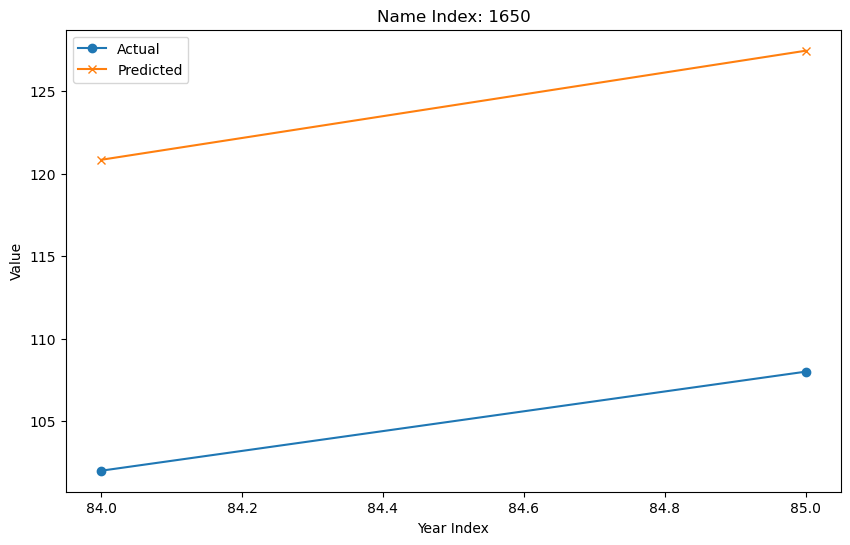

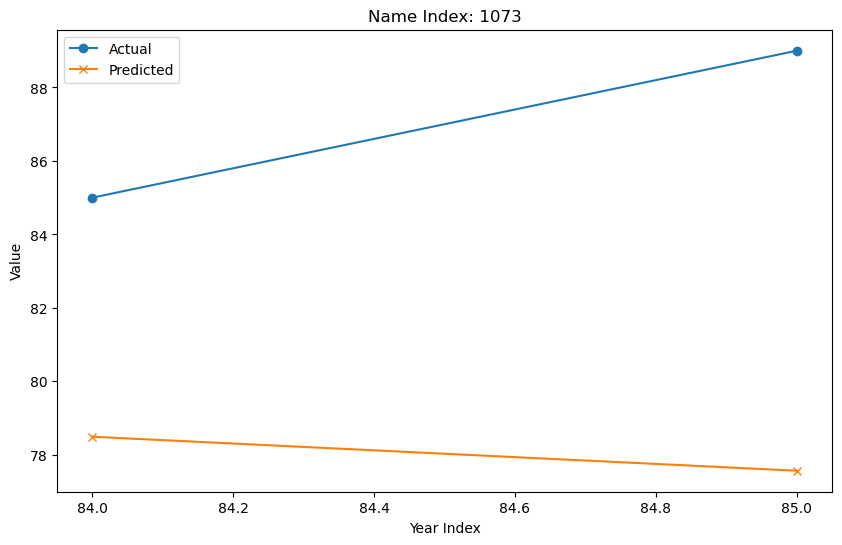

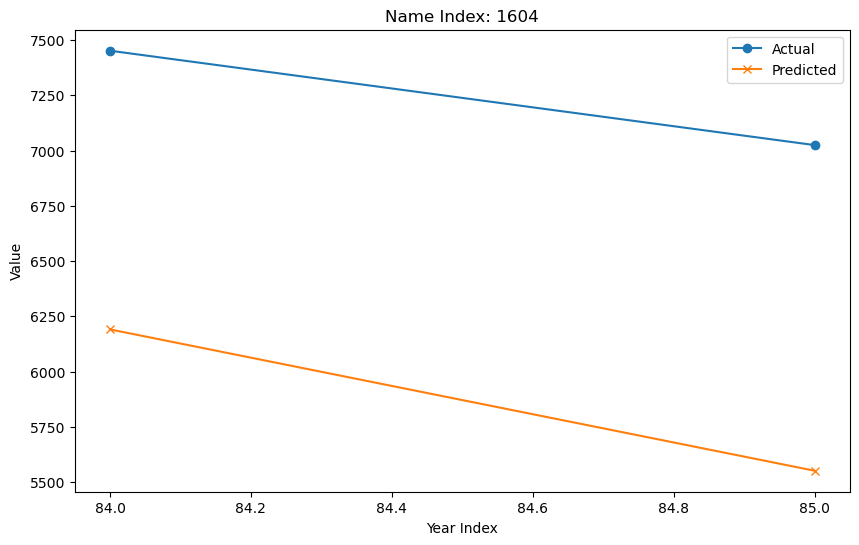

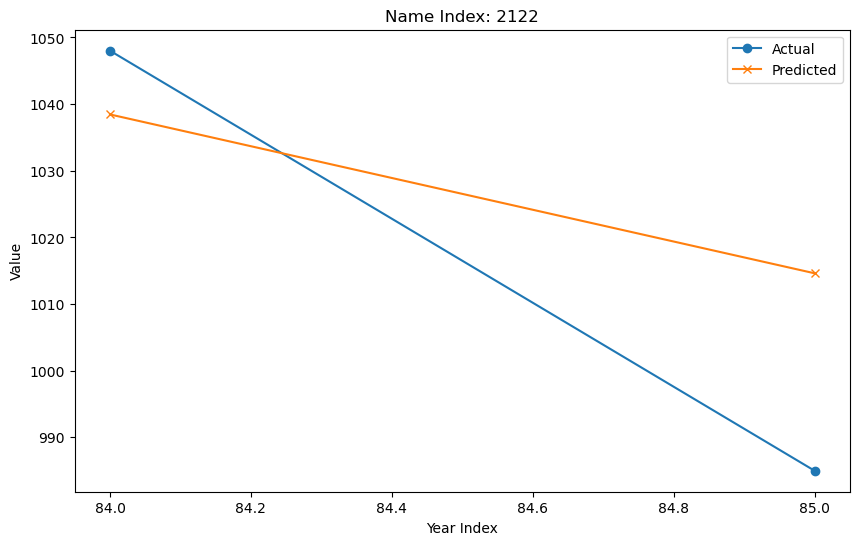

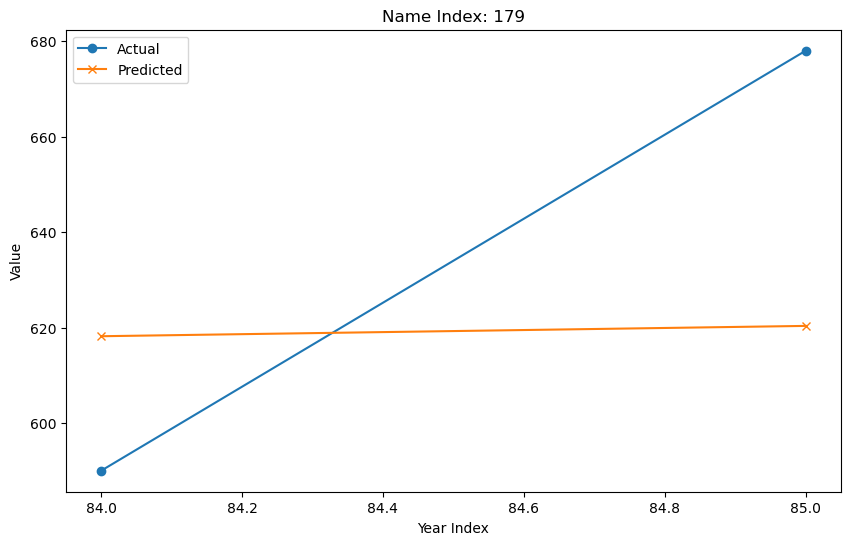

In [71]:
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(df3array.shape[1], 5, replace=False)

for index in selected_indices:
    actual_series = df3array[:, index][-n_steps_out:]  # Last `n_steps_out` actual values
    predicted_series = predicted_all[:, index]  # Predicted values for the series
    
    plt.figure(figsize=(10, 6))
    years = range(df3array.shape[0] - n_steps_out, df3array.shape[0])
    plt.plot(years, actual_series, label='Actual', marker='o')
    plt.plot(years, predicted_series, label='Predicted', marker='x')
    plt.title(f'Name Index: {index}')
    plt.xlabel('Year Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # If you want to print the RMSE for each series
    # rmse = np.sqrt(mean_squared_error(actual_series, predicted_series))
    # print(f'RMSE for Name Index {index}: {rmse:.2f}')


In [47]:
# this time split by name: in d3array, the names are columns 
cols = df3array.shape[1]
num_train_cols = int(cols * 0.8)

train_indices = np.random.choice(range(cols), size=num_train_cols, replace=False)
train = df3array[:, train_indices]

val_indices = np.setdiff1d(range(cols), train_indices)
val = df3array[:, val_indices]

X = train[:-num_years_to_predict,:]
y = train[-num_years_to_predict:,:]

val_X = val[:-num_years_to_predict,:]
val_y = val[-num_years_to_predict:,:]

In [48]:
def build_model(hp):
    n_steps_in = hp.Int('n_steps_in', min_value=3, max_value=30, step=1)
    n_steps_out = num_years_to_predict  # As defined before, for two years prediction
    X, y = split_sequences1(train, n_steps_in, n_steps_out)
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    n_features = X.shape[2]
    
    model = Sequential([
        Input(shape=(n_steps_in, n_features)),
        Conv1D(
            filters=hp.Int('filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size', values=[1, 2, 3]),
            activation='relu'
        ),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=50, max_value=200, step=50), activation='relu'),
        Dense(n_output)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

In [49]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

In [50]:
n_steps_in = 10  # Initial value
n_steps_out = num_years_to_predict
val_X, val_y = split_sequences1(val, n_steps_in, n_steps_out)
val_y = val_y.reshape((val_y.shape[0], val_y.shape[1] * val_y.shape[2]))

In [53]:
%%time
tuner.search(X, y, epochs=100, validation_data=(val_X, val_y), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Traceback (most recent call last):
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwa

Trial 2 Complete [00h 00m 00s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 00s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
8                 |27                |n_steps_in
128               |96                |filters
1                 |1                 |kernel_size
100               |150               |dense_units



RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py", line 114, in check_data_cardinality
    raise ValueError(msg)
ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 84
'y' sizes: 2



In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

In [ ]:
best_model.predict(...

In [27]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, n_output):
        self.input_shape = input_shape
        self.n_output = n_output
        
    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Choice('kernel_size', values=[2, 3]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units', min_value=50, max_value=200, step=50),
                        activation='relu'))
        model.add(Dense(self.n_output))
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='mse')
        return model

In [31]:
n_steps_in = 3
n_features = X2.shape[2]
n_output = y2.shape[1] * y2.shape[2]

hypermodel = CNNHyperModel(input_shape=(n_steps_in, n_features), n_output=n_output)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,  # Set a small number for example purposes
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_cnn'
)

tuner.search(X2, y2, epochs=10, validation_split=0.2, verbose=0)

/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
Traceback (most recent call last):
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/paulschickler/anaconda3/lib/

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1154, in mean_squared_error
    return ops.mean(ops.square(y_true - y_pred), axis=-1)
ValueError: Dimensions must be equal, but are 2 and 32 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](compile_loss/mse/Cast, sequential_1/dense_1_2/Add)' with input shapes: [32,2,2357], [32,4714].


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]